In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import nltk
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM
from keras.utils import to_categorical
from collections import Counter
nltk.download('averaged_perceptron_tagger')

%matplotlib inline

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\vivek\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
df = pd.read_csv("C:/Users/vivek/Downloads/train-balanced-sarcasm.csv")

In [3]:
df.describe()

,label,score,ups,downs
count,1010826.0,1.010826e+06,1.010826e+06,1.010826e+06
mean,0.5,6.885676e+00,5.498885e+00,-1.458629e-01
std,0.5,4.834288e+01,4.127297e+01,3.529689e-01
min,0.0,-5.070000e+02,-5.070000e+02,-1.000000e+00
25%,0.0,1.000000e+00,0.000000e+00,0.000000e+00
50%,0.5,2.000000e+00,1.000000e+00,0.000000e+00
75%,1.0,4.000000e+00,3.000000e+00,0.000000e+00
max,1.0,9.070000e+03,5.163000e+03,0.000000e+00


In [4]:
df.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1010773 entries, 0 to 1010825
Data columns (total 10 columns):
label             1010773 non-null int64
comment           1010773 non-null object
author            1010773 non-null object
subreddit         1010773 non-null object
score             1010773 non-null int64
ups               1010773 non-null int64
downs             1010773 non-null int64
date              1010773 non-null object
created_utc       1010773 non-null object
parent_comment    1010773 non-null object
dtypes: int64(4), object(6)
memory usage: 84.8+ MB


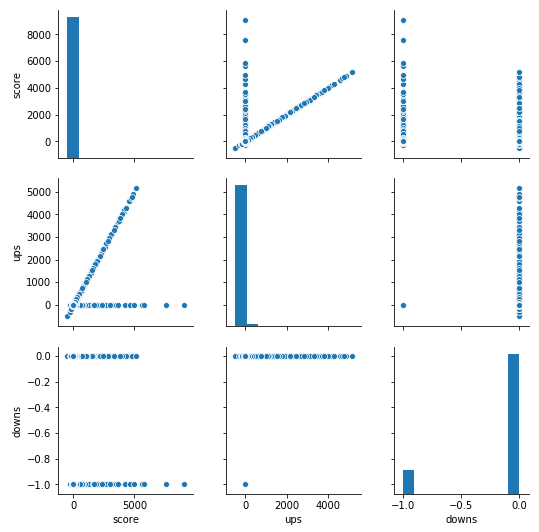

In [5]:
sns.pairplot(df[['score', 'ups', 'downs']])

In [6]:
df.shape

(1010826, 10)

In [7]:
df=df.dropna()

In [8]:
df.shape

(1010773, 10)

In [22]:
for sent in df['comment']:
    tokens=nltk.word_tokenize(sent)
    text = nltk.Text(tokens)
    tagged = nltk.pos_tag(text)
    counts = Counter(tag for word,tag in tagged)
    print(counts)

Counter({'NNP': 2, 'CC': 1, '.': 1})
Counter({'NNS': 3, 'VBP': 2, 'IN': 2, 'JJ': 2, 'PRP': 1, 'VB': 1, 'JJS': 1, 'RBR': 1, 'RB': 1, '.': 1})
Counter({'NN': 4, 'NNS': 2, ',': 2, 'NNP': 2, 'DT': 2, 'PRP': 1, 'VBD': 1, 'RBR': 1, 'CC': 1, 'IN': 1, 'POS': 1, 'VBZ': 1, 'VBN': 1, 'TO': 1, 'VB': 1})
Counter({'NN': 4, 'DT': 2, 'JJ': 2, 'VBZ': 1, 'RB': 1, 'IN': 1, '``': 1, "''": 1, 'NNS': 1, 'VBP': 1, '.': 1})
Counter({'PRP': 1, 'MD': 1, 'VB': 1, 'CD': 1, 'IN': 1, 'DT': 1, 'NNS': 1, '.': 1})
Counter({'PRP': 5, 'RB': 4, 'IN': 4, 'NN': 3, 'VB': 2, 'VBP': 1, 'TO': 1, 'PRP$': 1, ',': 1, 'CC': 1, 'VBZ': 1, 'JJ': 1, 'MD': 1, '(': 1, 'VBD': 1, 'DT': 1, ')': 1})
Counter({'JJ': 2, 'NNP': 1, 'CC': 1, 'VBG': 1, 'IN': 1, 'VBZ': 1, 'RB': 1, ':': 1})
Counter({'NNP': 3, 'CC': 1, '.': 1})
Counter({'PRP': 3, 'VB': 3, 'VBP': 2, ',': 2, 'RB': 1, 'TO': 1, 'DT': 1, 'JJ': 1, 'NN': 1, 'NNS': 1, 'CC': 1})
Counter({'PRP': 2, 'VB': 2, 'MD': 1, 'TO': 1, 'IN': 1, 'NN': 1, '.': 1})
Counter({'JJ': 2, 'NN': 2, 'IN': 2, 'NNS':

Counter({'JJ': 3, 'DT': 3, 'NN': 2, 'VBD': 2, 'PRP$': 1, 'RB': 1, 'TO': 1, 'IN': 1, 'WRB': 1, '.': 1})
Counter({'NNS': 2, 'RB': 2, 'IN': 1, 'PRP': 1, 'VBP': 1, 'VBG': 1, 'WDT': 1, 'MD': 1, 'VB': 1, '.': 1})
Counter({'NNP': 3, 'NNS': 1, 'VBP': 1, 'DT': 1})
Counter({'NN': 8, 'VBP': 5, 'RB': 4, 'DT': 2, 'IN': 2, ':': 1, 'VB': 1, 'PRP': 1, ',': 1, 'NNS': 1})
Counter({'JJ': 2, 'NN': 2, 'VBN': 1, 'TO': 1, 'WRB': 1, 'PRP': 1, 'VBD': 1, 'NNP': 1})
Counter({'JJ': 1, 'NN': 1, '.': 1})
Counter({'UH': 1, ',': 1, 'PRP': 1, 'VBP': 1, '.': 1})
Counter({'PRP': 2, 'NN': 2, 'RB': 1, 'VBP': 1, '``': 1, "''": 1, ',': 1, 'CC': 1, 'DT': 1, 'IN': 1, 'JJ': 1, 'WDT': 1, 'VBZ': 1, 'VBG': 1})
Counter({'NNP': 7, 'IN': 3, 'PRP': 3, 'DT': 2, 'NN': 2, 'VBD': 2, '``': 1, 'VBN': 1, 'NNS': 1, 'JJ': 1, 'CC': 1, 'TO': 1, 'VB': 1, "''": 1, 'VBZ': 1, 'PRP$': 1, '.': 1})
Counter({'NNP': 1, 'NN': 1})
Counter({'NN': 3, 'FW': 3, 'NNP': 1, 'NNS': 1, 'VBP': 1, '.': 1})
Counter({'NN': 1})
Counter({'IN': 3, 'PRP': 2, 'VBD': 2, 'NN

Counter({'PRP': 4, 'RB': 2, 'VBP': 2, 'VB': 2, 'NNP': 2, ',': 2, 'CC': 2, 'IN': 2, 'TO': 1, 'VBD': 1, 'WRB': 1, 'DT': 1, 'NNS': 1, 'EX': 1, 'VBZ': 1})
Counter({'NNP': 2, 'DT': 1, '.': 1})
Counter({'CD': 1, 'IN': 1, 'DT': 1, 'JJR': 1, 'NNP': 1, '.': 1})
Counter({'NN': 2, 'JJ': 1, 'VBD': 1, 'PRP$': 1, 'TO': 1, 'VB': 1, '.': 1})
Counter({'NN': 3, 'DT': 2, 'VBG': 2, 'NNP': 1, 'RB': 1, 'VBP': 1, 'PRP$': 1, 'VBN': 1, 'IN': 1, 'WDT': 1, 'PRP': 1, 'VBD': 1, 'TO': 1, 'VB': 1, 'VBZ': 1, 'JJR': 1, '.': 1})
Counter({'NN': 1, 'VBD': 1, 'RB': 1, 'VB': 1, 'WP': 1, 'DT': 1, 'VBZ': 1, '.': 1})
Counter({'NN': 2, '``': 1, 'JJ': 1, "''": 1, ':': 1})
Counter({'NN': 8, 'NNP': 6, ':': 4, 'JJ': 3, ',': 2, 'VBZ': 2, 'IN': 2, 'RB': 1, 'DT': 1, 'VBP': 1})
Counter({'VB': 2, 'IN': 2, 'NNS': 2, 'CD': 1, 'MD': 1, 'TO': 1, 'NN': 1, '.': 1})
Counter({'NN': 1})
Counter({'PRP': 1, 'VBP': 1, 'DT': 1, 'NN': 1, 'VBZ': 1, 'JJ': 1, 'NNS': 1, '.': 1})
Counter({'NN': 2, ',': 1, 'NNP': 1, ':': 1, 'JJ': 1, 'DT': 1})
Counter({'RB

Counter({'RB': 2, 'WRB': 1, ',': 1, 'JJ': 1, '.': 1})
Counter({'RB': 3, 'DT': 3, 'MD': 2, 'VB': 2, 'NN': 2, 'IN': 2, 'PRP': 1, 'NNP': 1, 'VBZ': 1, 'JJ': 1, 'CC': 1, 'VBN': 1, 'NNPS': 1, '.': 1})
Counter({'IN': 3, 'NN': 3, 'VBG': 2, 'WP': 1, 'JJ': 1, 'NNS': 1, 'VBZ': 1, 'WRB': 1, 'TO': 1, 'VB': 1, 'DT': 1, 'NNP': 1})
Counter({'VBD': 2, 'RB': 2, 'PRP': 1, 'VBN': 1, 'IN': 1, 'DT': 1, 'NNS': 1, 'CC': 1, 'VBG': 1, 'PRP$': 1, 'NN': 1, '.': 1})
Counter({'PRP': 3, 'VBP': 2, 'VB': 2, 'IN': 2, 'NN': 2, 'TO': 1, 'DT': 1, ',': 1, 'RB': 1, '.': 1})
Counter({'NNP': 2})
Counter({'CC': 1, 'NN': 1, ':': 1, 'CD': 1})
Counter({'$': 5, 'NNS': 1})
Counter({'NN': 2, 'DT': 1, 'JJ': 1, 'MD': 1, 'RB': 1, 'VB': 1, 'PRP': 1, 'IN': 1})
Counter({'DT': 5, 'NN': 5, 'PRP': 2, 'VBD': 2, 'IN': 2, 'VBG': 2, 'VBP': 1, 'JJ': 1, 'WP': 1, 'WDT': 1, 'VBZ': 1, 'NNP': 1, 'NNS': 1, '.': 1})
Counter({'NNP': 2, 'IN': 1, 'JJ': 1, 'NN': 1, '.': 1})
Counter({'DT': 2, 'NN': 2, 'JJ': 1, 'VBZ': 1, 'IN': 1, 'PRP': 1, 'VBP': 1, 'RBR': 1}

Counter({'DT': 1, 'JJ': 1, 'NN': 1})
Counter({'IN': 5, 'NN': 3, 'PRP': 3, 'RB': 2, 'DT': 1, 'NNP': 1, 'VBZ': 1, 'PRP$': 1, 'NNS': 1, ',': 1, 'VBP': 1, 'MD': 1, '.': 1})
Counter({'PRP': 2, 'VBP': 2, 'TO': 1, 'VB': 1, 'DT': 1, 'NN': 1})
Counter({'RB': 2, 'PRP': 2, '``': 1, ':': 1, 'MD': 1, 'VB': 1, 'RP': 1, 'IN': 1, 'JJ': 1, "''": 1, '.': 1})
Counter({'VBP': 1, 'RB': 1, 'VB': 1, 'PRP': 1, 'VBG': 1, 'NN': 1})
Counter({'JJ': 1, 'CC': 1, 'IN': 1, 'DT': 1, 'NN': 1})
Counter({'JJ': 3, 'NNS': 3, 'NN': 3, 'VBP': 2, 'DT': 2, 'IN': 2, 'UH': 1, ',': 1, 'NNP': 1, 'POS': 1, 'VBG': 1, 'RP': 1, 'PRP$': 1, '.': 1})
Counter({',': 2, 'JJ': 2, 'WRB': 1, 'NN': 1, 'PRP': 1, 'VBN': 1, '.': 1})
Counter({'NNP': 2, 'VBZ': 1, 'DT': 1, 'NN': 1})
Counter({'NNP': 2, 'NN': 1, 'IN': 1})
Counter({'NNP': 3, 'NN': 2, '``': 1, 'JJ': 1, "''": 1, 'IN': 1})
Counter({'IN': 3, ',': 2, 'NNS': 2, 'CD': 2, 'NNP': 1, 'VBN': 1, 'JJ': 1, 'NN': 1, 'VBZ': 1, 'RB': 1, '.': 1})
Counter({'VBN': 2, 'NNP': 2, 'PRP': 1, 'VBP': 1, 'RB': 1, 

Counter({'IN': 4, 'NN': 3, 'NNP': 2, 'RP': 2, ':': 2, '.': 2, 'PRP': 2, 'VBD': 2, 'POS': 1, 'RB': 1, 'DT': 1, 'JJ': 1, 'CC': 1, 'PRP$': 1, 'NNS': 1})
Counter({'PRP': 2, 'VB': 2, 'NNPS': 2, 'VBP': 1, 'RB': 1, 'JJ': 1, 'TO': 1, 'MD': 1, 'RP': 1, 'VBG': 1, 'NN': 1, 'IN': 1, 'DT': 1, '.': 1})
Counter({'DT': 2, 'NN': 2, 'IN': 2, 'RB': 2, 'NNP': 2, '``': 1, 'JJ': 1, "''": 1, ':': 1, 'MD': 1, 'VB': 1, '.': 1})
Counter({'JJ': 4, 'NNS': 3, 'PRP': 3, 'CC': 2, 'DT': 2, 'VBP': 2, 'UH': 1, 'VBD': 1, 'VBZ': 1, 'RB': 1, 'IN': 1, '.': 1})
Counter({'VB': 2, 'NN': 2, 'MD': 1, 'IN': 1, 'DT': 1})
Counter({'NNP': 7, ',': 2, 'DT': 1, 'PRP': 1})
Counter({'VBG': 3, 'PRP$': 2, 'NNS': 2, 'NN': 2, 'JJ': 2, ',': 1, 'IN': 1, 'CC': 1, 'VBZ': 1, 'RB': 1, ':': 1})
Counter({'NN': 16, 'IN': 12, 'DT': 10, 'JJ': 8, 'PRP': 7, 'RB': 7, ',': 5, 'VBD': 5, 'VBZ': 5, 'VB': 4, 'PRP$': 4, 'CC': 3, 'NNS': 2, '(': 2, 'VBG': 2, ')': 2, 'TO': 2, 'WDT': 2, 'WP': 1, 'VBP': 1, 'RP': 1, 'VBN': 1, '``': 1, "''": 1, 'WRB': 1, '.': 1})
Cou

Counter({'NN': 6, '(': 6, ')': 6, 'NNP': 5, 'CD': 5, ',': 3, 'JJ': 1, 'VBP': 1, 'VBZ': 1, 'CC': 1, 'RB': 1, '.': 1})
Counter({'PRP': 2, 'NNS': 1, 'IN': 1, 'VBP': 1, 'VBG': 1})
Counter({'RB': 4, 'NN': 3, 'DT': 2, 'IN': 1, 'JJ': 1, 'TO': 1, 'VB': 1, 'PRP': 1, ',': 1, 'PRP$': 1, 'CC': 1, 'VBP': 1, 'WP': 1, 'VBZ': 1})
Counter({'NNS': 1})
Counter({'RB': 3, ':': 2, 'PRP': 2, 'VB': 2, 'JJ': 1, 'NNS': 1, 'MD': 1, 'IN': 1, 'DT': 1, 'NN': 1, ')': 1})
Counter({'NN': 1})
Counter({'PRP': 1, 'VBP': 1, 'IN': 1, 'DT': 1, 'NN': 1})
Counter({'PRP': 1, 'VBP': 1, 'VBG': 1, 'DT': 1, 'NNP': 1, 'NN': 1, 'RB': 1, '.': 1})
Counter({'PRP': 6, 'IN': 5, 'VBD': 4, 'NNP': 4, 'NN': 3, 'VBG': 2, 'PRP$': 2, 'NNS': 2, 'DT': 2, 'TO': 2, 'WRB': 1, 'VBP': 1, ',': 1, 'CC': 1, 'CD': 1, 'VBN': 1, 'VB': 1, 'WDT': 1, '``': 1, 'RP': 1, "''": 1})
Counter({'NNP': 2, 'IN': 1, 'JJ': 1, 'NN': 1, 'RB': 1})
Counter({'PRP': 4, 'VBP': 3, 'VBG': 2, 'NN': 2, 'RB': 2, ',': 1, 'VB': 1, 'JJ': 1, 'CC': 1, 'PRP$': 1, 'NNS': 1, '.': 1})
Counter

Counter({'NN': 2, 'JJ': 1, ',': 1, 'WRB': 1, 'VBP': 1, 'NNP': 1, 'NNS': 1, '.': 1})
Counter({'NN': 6, 'IN': 3, 'RB': 2, 'DT': 2, 'CC': 2, 'NNP': 1, 'PRP': 1, 'VBP': 1, 'PRP$': 1, 'VBZ': 1, 'VB': 1, '.': 1})
Counter({'VBP': 1, 'DT': 1, 'JJ': 1, 'NNS': 1, '.': 1})
Counter({'PRP': 4, 'MD': 3, 'VBN': 3, 'VBD': 3, 'VB': 3, 'NN': 3, 'RB': 3, 'DT': 2, 'VBG': 2, 'TO': 2, 'IN': 2, 'PRP$': 2, ':': 2, 'VBP': 1, 'WRB': 1, 'NNP': 1, '#': 1, 'JJ': 1, ',': 1, '.': 1})
Counter({'NN': 3, 'RB': 3, 'VBD': 1, 'DT': 1, 'IN': 1, ',': 1, 'CC': 1, 'NNP': 1, 'NNS': 1, 'VBP': 1, '``': 1, 'JJ': 1, "''": 1})
Counter({'RB': 2, 'NNP': 1, ',': 1, 'JJ': 1, '.': 1})
Counter({'IN': 3, 'JJ': 2, 'NNS': 2, 'NN': 2, 'VBP': 1, 'WRB': 1, 'CD': 1, 'VBZ': 1, 'TO': 1, 'VB': 1, 'DT': 1, '.': 1})
Counter({'VBZ': 2, 'PRP': 1, 'DT': 1, 'NNP': 1, ',': 1, 'WDT': 1, 'IN': 1, 'JJ': 1})
Counter({'NN': 6, 'DT': 3, 'TO': 3, 'PRP': 2, 'RB': 2, 'VB': 2, 'NNS': 2, 'CC': 2, 'VBP': 1, 'JJ': 1, '(': 1, ')': 1, ',': 1, 'VBZ': 1, 'IN': 1, '.': 1}

Counter({'DT': 2, ',': 1, 'VBZ': 1, 'NNP': 1})
Counter({'VB': 2, 'DT': 2, 'NN': 2, 'NNP': 2, 'VBP': 1, 'RB': 1, 'IN': 1, '.': 1})
Counter({'NNP': 2, 'VBZ': 1, 'RB': 1, '.': 1})
Counter({'PRP': 3, 'VB': 2, 'IN': 1, 'VBP': 1, 'VBG': 1, 'TO': 1, 'NN': 1, ',': 1, 'MD': 1, '.': 1})
Counter({'DT': 2, 'NN': 2, 'VBD': 2, 'PRP': 2, 'JJ': 2, ',': 1, 'WP': 1, 'VBZ': 1, '.': 1})
Counter({'UH': 1, ',': 1, 'DT': 1, 'RB': 1, ':': 1})
Counter({'PRP': 1, 'MD': 1, 'VB': 1, 'VBN': 1, '.': 1})
Counter({'VBP': 4, 'PRP': 2, 'VBN': 2, 'JJ': 1, 'CC': 1, 'NN': 1, '.': 1})
Counter({'PRP': 4, 'IN': 1, 'VBD': 1, 'WDT': 1, 'MD': 1, 'RB': 1, 'VB': 1, 'DT': 1, 'RBR': 1, 'JJ': 1})
Counter({'DT': 3, 'NN': 3, 'IN': 3, 'NNP': 3, 'CC': 3, 'VBN': 3, 'NNS': 3, 'VB': 2, 'MD': 1, 'RP': 1, ',': 1, 'VBZ': 1, 'JJ': 1, 'TO': 1, '.': 1})
Counter({'NN': 7, 'DT': 6, 'IN': 5, 'VBZ': 4, 'NNP': 3, 'JJ': 3, 'TO': 3, 'VBN': 2, 'VB': 2, 'PRP': 2, 'CC': 1, 'RB': 1, ',': 1, 'EX': 1, 'VBG': 1, '.': 1})
Counter({'DT': 1, 'JJ': 1, 'NN': 1, 'P

Counter({'IN': 2, 'NN': 2, 'VBZ': 1, '.': 1})
Counter({'DT': 7, 'NNS': 5, 'IN': 5, 'RB': 4, 'NN': 3, 'EX': 2, 'VBP': 2, 'VBG': 2, ',': 2, 'CC': 2, 'VBZ': 1, 'TO': 1, 'VB': 1, 'NNP': 1, '.': 1})
Counter({'PRP': 2, 'WRB': 1, 'VBP': 1, 'VBG': 1, 'IN': 1, 'DT': 1})
Counter({'JJ': 2, 'NNS': 2, 'VB': 1, 'WP': 1, 'DT': 1, 'NN': 1, ',': 1, 'VBG': 1, 'CD': 1, 'IN': 1})
Counter({'DT': 1, 'NNS': 1, 'VBP': 1, 'RB': 1, 'VBN': 1, '.': 1})
Counter({'NN': 2, 'NNP': 1, 'VBD': 1, '``': 1, 'JJS': 1, "''": 1, 'IN': 1, 'RB': 1, 'WRB': 1, 'PRP': 1, 'TO': 1, 'CD': 1, 'JJ': 1, 'NNS': 1})
Counter({'PRP': 6, 'VB': 4, 'RB': 4, 'VBD': 3, 'CC': 3, 'MD': 3, ',': 2, 'CD': 2, 'TO': 1, 'DT': 1, 'NNS': 1, 'IN': 1, 'VBN': 1, 'NNP': 1, 'JJR': 1, 'NN': 1, 'PRP$': 1, '(': 1, 'RBR': 1, 'JJ': 1, ')': 1})
Counter({'RB': 4, 'NN': 3, 'IN': 2, 'DT': 2, 'VBG': 1, 'JJ': 1, 'VBZ': 1, 'NNS': 1, 'MD': 1, 'VB': 1, 'PRP$': 1})
Counter({'NN': 1, '.': 1})
Counter({'NN': 2, 'NNP': 1, 'CC': 1})
Counter({'RB': 1, 'NNP': 1, 'VBZ': 1, 'DT': 1

Counter({'RB': 3, 'PRP': 3, 'JJ': 3, 'VBP': 2, 'CC': 2, 'IN': 1, ',': 1, 'VBZ': 1, 'PRP$': 1, 'NN': 1, '.': 1})
Counter({'PRP': 3, 'RB': 2, 'VBD': 1, 'DT': 1, 'NNP': 1, 'MD': 1, 'VB': 1, 'TO': 1, 'IN': 1, 'VBZ': 1, 'PRP$': 1, 'JJ': 1, 'NN': 1})
Counter({'NNP': 2})
Counter({'WRB': 1, 'JJ': 1, 'VBZ': 1, 'DT': 1, '.': 1})
Counter({'NNP': 20, 'IN': 3, ',': 3, 'POS': 1})
Counter({'VBP': 1, 'PRP': 1, 'VBN': 1, 'TO': 1, 'DT': 1, 'NNP': 1, 'NN': 1, '.': 1})
Counter({'IN': 2, 'NNP': 2, 'MD': 1, 'PRP': 1, 'VB': 1, 'DT': 1, 'NN': 1, 'RB': 1, 'POS': 1, 'CC': 1, '.': 1})
Counter({'NN': 6, 'DT': 3, 'VBZ': 2, 'IN': 2, 'VBG': 2, 'JJ': 1, 'CC': 1, 'CD': 1, 'NNS': 1, '.': 1})
Counter({'NN': 3, 'NNS': 1, 'WRB': 1, 'VBZ': 1, 'VBG': 1, '.': 1})
Counter({'DT': 3, 'NN': 3, 'WRB': 1, 'CC': 1, 'VB': 1, ':': 1})
Counter({'JJ': 2, 'NN': 2, 'DT': 1, ',': 1})
Counter({'VBN': 4, 'NN': 4, 'DT': 3, 'RB': 3, 'PRP': 2, 'VBP': 2, 'VBD': 2, 'CC': 2, 'NNS': 2, 'IN': 1, 'VBZ': 1, 'NNP': 1, 'VBG': 1, 'JJ': 1, 'CD': 1})
Coun

Counter({'NN': 5, 'RB': 4, 'VBG': 3, 'IN': 3, 'VB': 2, 'PRP$': 2, 'CC': 1, 'TO': 1, ',': 1, 'VBZ': 1, 'JJ': 1})
Counter({'NN': 1, '.': 1})
Counter({'DT': 1, 'NN': 1, 'NNS': 1, '.': 1})
Counter({'PRP': 7, 'VBP': 4, 'VBZ': 3, 'DT': 3, 'CC': 2, 'IN': 2, 'NN': 2, 'RP': 2, 'VB': 2, 'JJ': 1, 'RB': 1, 'NNS': 1, 'TO': 1, 'WRB': 1, 'VBG': 1})
Counter({'PRP': 1, 'VBP': 1, 'NNS': 1, ',': 1, 'NN': 1, '.': 1})
Counter({'NN': 4, 'VB': 4, 'VBP': 3, 'NNS': 3, 'IN': 2, 'TO': 2, 'NNP': 1, 'JJ': 1, 'VBZ': 1, 'VBG': 1, 'VBN': 1, 'WP': 1, 'DT': 1, 'PRP': 1, 'JJR': 1, 'PRP$': 1, 'CC': 1})
Counter({':': 1, ')': 1, 'PRP': 1, 'VBP': 1, 'JJ': 1, 'NN': 1, '.': 1})
Counter({'DT': 1, 'JJ': 1, 'NN': 1})
Counter({'``': 1, 'NN': 1, "''": 1})
Counter({'NN': 6, 'NNP': 2, 'JJ': 2, ':': 2, ',': 1, 'VBP': 1, 'VBN': 1, 'IN': 1, 'TO': 1, 'PRP$': 1})
Counter({'NN': 3, 'PRP': 1, 'VBP': 1, 'DT': 1, 'IN': 1, 'RB': 1, 'JJ': 1})
Counter({'IN': 2, 'VBG': 1, 'NN': 1, '.': 1})
Counter({'VB': 3, 'NN': 3, 'IN': 2, 'TO': 1, 'NNS': 1, '

Counter({'VBZ': 2, 'JJR': 2, 'RB': 2, 'NN': 1, 'VBN': 1, 'VBG': 1, 'CC': 1, 'NNS': 1, '.': 1})
Counter({'JJ': 2, 'NN': 1, 'VBD': 1, 'PRP': 1, 'MD': 1, 'VB': 1, 'VBN': 1, 'IN': 1, 'VBG': 1, 'RB': 1, '.': 1})
Counter({'CC': 1, 'IN': 1, 'JJS': 1, 'PRP': 1, 'VBD': 1, 'PRP$': 1, 'JJ': 1, 'NNS': 1, 'TO': 1, 'VB': 1, '.': 1})
Counter({'VBP': 2, 'IN': 2, 'JJ': 2, 'PRP': 1, 'NNS': 1, 'DT': 1, 'NN': 1, 'NNP': 1, '.': 1})
Counter({'PRP': 5, 'VBP': 3, 'IN': 3, 'TO': 2, 'VB': 2, 'VBZ': 1, 'NN': 1, 'JJ': 1, 'NNS': 1, '.': 1})
Counter({'NN': 3, 'PRP': 1, 'VBP': 1, 'DT': 1, '.': 1})
Counter({'IN': 1, 'PRP': 1, 'RB': 1})
Counter({'JJ': 2, 'NN': 2, 'IN': 1, ',': 1, 'VBZ': 1, '.': 1})
Counter({'NNP': 1, '.': 1})
Counter({'PRP': 2, 'IN': 1, 'VBP': 1, 'VBG': 1, 'JJ': 1, ',': 1, 'RB': 1, 'VBZ': 1, 'NNP': 1})
Counter({'IN': 1, 'NNP': 1, 'PRP': 1, 'MD': 1, 'VB': 1, 'DT': 1, 'NN': 1, '.': 1})
Counter({'RB': 2, 'JJ': 1, 'NN': 1, '.': 1})
Counter({'RB': 3, 'VB': 2, 'PRP': 1, 'WRB': 1, 'JJ': 1, 'NNP': 1, 'MD': 1,

Counter({'NN': 7, 'DT': 4, 'IN': 4, 'NNP': 4, 'JJ': 4, ',': 3, 'PRP': 3, 'VBG': 3, 'NNS': 3, '``': 2, 'RB': 1, 'MD': 1, 'VB': 1, 'WRB': 1, ':': 1, 'VBP': 1, 'VBZ': 1, 'CC': 1, '.': 1})
Counter({'WP': 1, 'VBP': 1, 'PRP': 1, 'VBG': 1, 'IN': 1, 'NN': 1, 'TO': 1, '.': 1})
Counter({'PRP': 3, 'RB': 3, 'VBZ': 2, 'NN': 2, ':': 2, 'VBP': 1, 'WRB': 1, 'CC': 1, 'NNS': 1, 'IN': 1, '``': 1, 'NNP': 1, 'PRP$': 1, 'VBD': 1, 'DT': 1, "''": 1})
Counter({'RB': 2, 'PRP': 2, 'VBP': 2, 'WRB': 1, '.': 1})
Counter({'PRP': 5, 'NN': 4, 'VBP': 3, 'IN': 3, 'RB': 3, 'DT': 2, 'MD': 1, 'VB': 1, 'JJ': 1})
Counter({'NNS': 1, '.': 1})
Counter({'VBP': 2, 'JJ': 2, 'PRP': 2, 'DT': 1, 'NNP': 1, "''": 1, ':': 1, '.': 1, 'IN': 1, 'RB': 1, 'VBZ': 1})
Counter({'VBG': 1, 'DT': 1, 'JJ': 1, 'NN': 1, 'RB': 1, 'IN': 1})
Counter({'DT': 4, 'NNP': 2, ',': 1, 'VBD': 1, 'PRP': 1, '.': 1})
Counter({'NNP': 2, 'PRP': 2, 'VB': 2, 'NN': 2, 'VBG': 1, ',': 1, 'MD': 1, 'RB': 1, 'RP': 1, 'CC': 1, 'PRP$': 1, 'IN': 1, 'DT': 1, '.': 1})
Counter({'N

Counter({'NN': 4, 'DT': 2, ':': 2, 'VBP': 1, 'WRB': 1, 'VBZ': 1, 'RP': 1, 'IN': 1, 'RB': 1, 'CC': 1, 'NNS': 1, ')': 1})
Counter({'NN': 3, 'VB': 2, 'DT': 2, ':': 1, 'TO': 1, ',': 1, 'JJ': 1, 'NNP': 1, 'IN': 1})
Counter({'NNP': 2})
Counter({'DT': 1, ',': 1, 'PRP': 1, 'MD': 1, 'RB': 1, '.': 1})
Counter({'NNS': 1, 'IN': 1, 'DT': 1, 'NN': 1, '.': 1})
Counter({'NN': 1, 'VBZ': 1, 'VBN': 1})
Counter({'NNP': 4})
Counter({'PRP': 2, 'VB': 2, 'VBP': 1, 'MD': 1, '.': 1})
Counter({'PRP': 1, 'VBP': 1, 'IN': 1, 'DT': 1, 'NN': 1, '.': 1})
Counter({'PRP': 2, 'WRB': 1, 'MD': 1, 'VB': 1, 'IN': 1, 'DT': 1, '.': 1})
Counter({'NNP': 3, 'VBN': 3, 'IN': 2, 'VB': 2, 'CC': 2, 'JJ': 1, ':': 1, 'NN': 1, 'MD': 1, 'RB': 1, ',': 1, 'VBZ': 1, 'NNS': 1, 'TO': 1})
Counter({'NNP': 2, 'VBP': 1, 'CD': 1})
Counter({'PRP': 3, 'NN': 3, 'MD': 2, 'VB': 2, 'IN': 2, 'CC': 2, 'NNS': 2, ',': 2, 'JJ': 2, 'DT': 1, 'VBZ': 1, 'RB': 1, 'TO': 1, 'CD': 1, '.': 1})
Counter({'RB': 4, 'PRP': 3, ',': 2, 'VBP': 2, 'IN': 2, 'DT': 1, 'VBZ': 1, '

Counter({'CD': 2, 'VB': 1, '.': 1})
Counter({'NN': 3, 'PRP': 2, 'VBP': 2, 'RB': 2, 'IN': 2, 'DT': 2, 'RP': 1, 'VB': 1, 'JJ': 1, '.': 1})
Counter({'DT': 2, 'RB': 2, 'VBG': 2, 'IN': 2, 'PRP': 1, 'VBP': 1, 'VBN': 1, 'NN': 1, 'TO': 1, 'VB': 1, 'PRP$': 1, 'NNS': 1})
Counter({'CC': 1, 'DT': 1, 'RB': 1, 'VBZ': 1, 'IN': 1, 'VBD': 1, 'VBG': 1, 'RP': 1, 'NNP': 1, 'NN': 1, 'NNS': 1})
Counter({'CD': 2, 'TO': 1, 'NNPS': 1, 'VBP': 1, 'NN': 1, '.': 1})
Counter({'NNP': 4, ',': 3})
Counter({'IN': 3, 'NNP': 3, 'NN': 3, 'JJ': 3, 'VBD': 2, ',': 2, 'CC': 2, 'PRP': 2, 'VB': 2, 'RP': 1, '(': 1, 'WDT': 1, 'VBZ': 1, 'PRP$': 1, ')': 1, 'VBN': 1, 'MD': 1, 'VBG': 1, 'TO': 1})
Counter({'PRP': 2, 'NN': 2, 'NNP': 1, 'VBP': 1, 'WRB': 1, 'JJ': 1, 'VBZ': 1, 'PRP$': 1, 'IN': 1, 'MD': 1, 'RB': 1, 'VB': 1, 'DT': 1})
Counter({'NN': 3, 'VB': 1, ':': 1, ',': 1, '.': 1})
Counter({'PRP': 2, 'VB': 2, 'MD': 1, 'PRP$': 1, 'NN': 1, 'RB': 1, 'TO': 1, 'JJ': 1})
Counter({'IN': 1, 'DT': 1, 'NNP': 1, 'VBP': 1, 'JJ': 1, 'NNS': 1})
Count

Counter({'PRP': 3, 'VB': 2, 'MD': 1, 'PRP$': 1, 'NNS': 1, 'CC': 1, 'WRB': 1, 'VBP': 1, 'TO': 1, '.': 1})
Counter({'NNP': 2, ',': 1, 'IN': 1, 'JJ': 1})
Counter({'NNP': 1, 'NN': 1, 'IN': 1, 'DT': 1, 'NNS': 1})
Counter({'JJ': 4, 'DT': 2, 'VBZ': 1, 'NN': 1, ',': 1, 'NNS': 1, 'VBP': 1, 'CC': 1, '.': 1})
Counter({'DT': 1, 'VBZ': 1, 'JJ': 1})
Counter({'VBZ': 2, 'DT': 1, 'JJR': 1, 'NN': 1, ',': 1, 'EX': 1, 'CD': 1, 'IN': 1, 'PRP': 1, '.': 1})
Counter({'NNP': 2, 'JJ': 2, 'NNS': 2, 'PRP$': 2, 'MD': 1, 'VB': 1, 'DT': 1, 'RB': 1, 'VBP': 1, 'TO': 1, 'NN': 1, 'VBZ': 1, 'RBR': 1, 'IN': 1})
Counter({'MD': 1, 'RB': 1, 'VB': 1, 'JJR': 1, 'JJ': 1})
Counter({'NNP': 2, 'RB': 2, 'NN': 1, ',': 1, 'VBD': 1, 'EX': 1, 'VBZ': 1, 'DT': 1, 'CD': 1, '.': 1})
Counter({'PRP': 1, 'VBP': 1, 'RB': 1, 'VBN': 1, 'CD': 1, 'IN': 1, 'DT': 1})
Counter({'NN': 2, 'DT': 2, 'TO': 1, 'CC': 1, 'NNP': 1, '.': 1})
Counter({'IN': 2, 'RB': 2, 'DT': 1, 'JJ': 1, 'TO': 1, 'NN': 1, ',': 1, 'PRP': 1, 'VBP': 1, 'VBN': 1, 'NNP': 1, '.': 1})
C

Counter({'CD': 3, 'NNS': 2, 'IN': 1, 'VBZ': 1})
Counter({'NN': 2, 'DT': 1, 'VBZ': 1, 'IN': 1, 'VBN': 1, 'RP': 1, 'JJ': 1})
Counter({'EX': 1, 'VBP': 1, 'JJ': 1, 'NNS': 1, '.': 1})
Counter({'VBN': 3, 'IN': 3, 'NN': 3, 'PRP': 1, 'VBD': 1, 'JJ': 1, 'CC': 1, ',': 1, 'WP': 1, 'VBZ': 1})
Counter({'VB': 2, 'NN': 2, 'RB': 1, 'DT': 1, 'VBN': 1, 'TO': 1, 'IN': 1, 'JJ': 1, 'NNS': 1, '.': 1})
Counter({'NN': 1})
Counter({'DT': 2, 'VBD': 1, 'RB': 1, 'MD': 1, 'VB': 1, 'JJ': 1, 'NN': 1})
Counter({'PRP': 6, 'VBD': 3, 'RB': 3, 'VB': 2, 'NNS': 2, 'VBZ': 1, 'JJ': 1, 'TO': 1, 'CC': 1, 'VBN': 1, 'MD': 1, 'WDT': 1, 'VBP': 1, 'NN': 1, '.': 1})
Counter({'``': 1, 'JJ': 1, "''": 1})
Counter({'JJ': 3, ':': 1, 'IN': 1, 'NNS': 1, ',': 1, 'RB': 1, 'NN': 1})
Counter({'CD': 1})
Counter({'JJ': 4, 'IN': 3, 'NNP': 3, ',': 2, 'NN': 2, 'PRP': 1, 'VBZ': 1, 'PRP$': 1, 'DT': 1, 'CC': 1, 'NNS': 1})
Counter({'RB': 4, 'PRP': 4, 'VB': 3, 'VBD': 2, 'NN': 2, 'TO': 2, '``': 1, 'JJ': 1, "''": 1, 'CC': 1, 'NNP': 1, 'IN': 1, ',': 1, 'PR

Counter({'VBG': 1, 'IN': 1, 'DT': 1, 'NN': 1, '.': 1})
Counter({'PRP': 2, 'TO': 1, ',': 1, 'VBZ': 1, 'VBN': 1, 'JJ': 1, 'IN': 1, 'NNS': 1, ':': 1})
Counter({'PRP': 3, 'VBP': 3, 'JJ': 1, 'DT': 1, 'NN': 1, 'VBG': 1, ':': 1, ')': 1})
Counter({'NN': 6, 'VB': 4, 'PRP': 3, 'DT': 3, ',': 2, 'TO': 2, 'VBZ': 2, 'MD': 1, 'PRP$': 1, 'CC': 1, 'IN': 1, 'RB': 1, '.': 1})
Counter({'NN': 2, 'PRP': 1, 'VBP': 1, 'PRP$': 1, 'IN': 1, 'DT': 1, '.': 1})
Counter({'PRP': 4, 'VBP': 3, 'RB': 3, 'VB': 2, 'DT': 1, ',': 1, 'JJ': 1, 'NNS': 1, '.': 1})
Counter({'NN': 1, 'TO': 1, 'VB': 1, 'IN': 1, 'PRP$': 1, 'NNS': 1, '.': 1})
Counter({'DT': 1, 'VBZ': 1, 'NN': 1, '.': 1})
Counter({'NN': 3, 'PRP': 2, 'VBP': 2, 'JJ': 1, 'NNS': 1, 'VBN': 1, '.': 1})
Counter({'NN': 2, 'PRP': 1, 'VBP': 1, 'TO': 1, 'VB': 1, 'DT': 1, 'JJ': 1})
Counter({'IN': 5, 'NN': 3, 'DT': 3, 'VBP': 2, 'CC': 2, 'CD': 2, 'JJ': 2, 'VBZ': 2, 'PRP': 1, 'NNP': 1, 'VBN': 1, ',': 1, 'RB': 1, 'WDT': 1, '.': 1})
Counter({'DT': 1, '.': 1})
Counter({'VB': 2, 'UH': 

Counter({'VBP': 5, 'PRP': 4, 'IN': 3, 'TO': 2, 'VB': 2, 'NN': 2, ',': 2, 'RB': 2, 'VBG': 1, 'DT': 1, 'NNP': 1, 'CC': 1, '.': 1})
Counter({'VBN': 2, 'NNP': 1, ',': 1, 'PRP': 1, 'VBP': 1, 'RB': 1, 'NN': 1, 'VBZ': 1, '.': 1})
Counter({'JJ': 1, 'NNS': 1, '.': 1})
Counter({'NN': 3, 'PRP': 2, 'IN': 2, 'JJ': 2, 'DT': 2, '``': 1, 'MD': 1, 'RB': 1, 'VB': 1, 'PRP$': 1, 'CC': 1, 'VBZ': 1, "''": 1})
Counter({'IN': 1, 'RB': 1, '.': 1})
Counter({'RB': 2, 'NN': 1, 'NNS': 1, 'VBP': 1, 'JJ': 1})
Counter({'NN': 2, 'PRP': 1, 'VBZ': 1, 'DT': 1, 'JJ': 1, '.': 1})
Counter({'PRP': 1, 'VBP': 1, 'DT': 1, 'NN': 1})
Counter({'PRP': 3, 'NN': 2, 'WRB': 2, 'VB': 2, 'IN': 1, 'NNP': 1, 'VBZ': 1, 'NNS': 1, 'VBP': 1, 'PRP$': 1, 'JJ': 1, 'CC': 1, 'RB': 1, 'RP': 1, '.': 1})
Counter({'NN': 3, 'IN': 2, 'VB': 2, 'PRP': 1, 'VBP': 1, 'NNS': 1, 'NNP': 1, 'DT': 1, ',': 1, 'POS': 1, 'PRP$': 1, 'RB': 1, '.': 1})
Counter({'NN': 1})
Counter({'DT': 5, 'PRP': 4, 'VBZ': 3, 'NN': 3, 'IN': 2, 'RB': 2, 'TO': 1, 'JJ': 1, 'VBN': 1, 'NNP': 

KeyboardInterrupt: 

In [27]:
[x for x in counts]

['PRP', 'VBZ', 'JJ', ',', 'PRP$', 'NN', 'IN', 'JJR', 'NNS', '.']

In [10]:
tokens = nltk.word_tokenize(df['comment'])

TypeError: expected string or bytes-like object

In [30]:
text = df['comment']
text = text.apply(lambda x: x.lower())

In [32]:
batch_size = 5000
tokenizer = Tokenizer(num_words=batch_size, split=' ')
tokenizer.fit_on_texts(text.values)
X = tokenizer.texts_to_sequences(text.values)

In [33]:
X = pad_sequences(X)

In [47]:
Y = df['label']
Y = to_categorical(Y)

In [49]:
embed_dim=128
lstm_out=256
model = Sequential()
model.add(Embedding(batch_size, embed_dim, input_length=X.shape[1], dropout=0.2))
model.add(LSTM(lstm_out, dropout=0.2))
model.add(Dense(2, activation='softmax'))

C:\Users\vivek\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: The `dropout` argument is no longer support in `Embedding`. You can apply a `keras.layers.SpatialDropout1D` layer right after the `Embedding` layer to get the same behavior.
  after removing the cwd from sys.path.


In [50]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 2222, 128)         640000    
_________________________________________________________________
lstm_3 (LSTM)                (None, 256)               394240    
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 514       
Total params: 1,034,754
Trainable params: 1,034,754
Non-trainable params: 0
_________________________________________________________________


In [51]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.fit(X, Y, nb_epoch=2, batch_size=128, verbose=2)

C:\Users\vivek\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.
W0718 19:22:27.530964 14384 deprecation.py:323] From C:\Users\vivek\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/2
